# 6COSC017C-n, Machine Learning and Data Analytics 

# Importing Required Libraries

In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder



# Loading dataset

In [ ]:
df = pd.read_csv("./data/wdi001.csv", thousands=',')

# Displaying first 5 rows
df.head()

In [ ]:
# Dataset shape
print("Dataset shape (rows, columns):", df.shape)

In [ ]:
# Dataset info
print("Dataset info:", df.info())

# Exploratory Data Analysis (EDA)

In [ ]:
print("Summary statistics:")
display(df.describe())

In [ ]:
print("\nMissing values per column:")
print(df.isnull().sum())

In [ ]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numeric columns:", numeric_cols)


In [ ]:
# Plot feature distributions for all numeric features
features = [col for col in numeric_cols]
for feature in features:
    plt.figure(figsize=(8,4))
    sns.histplot(df[feature], kde=True, bins=50)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


In [ ]:
# Detect outliers (boxplots) for all numeric columns
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [ ]:
# Compute and visualize correlation matrix for numeric columns
plt.figure(figsize=(15,12))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Data Preparation.

In [ ]:
df_clean = df.copy()

In [ ]:
# Remove non-useful categorical columns

drop_cat_cols = [
    'ISO2 Code',                  # redundant with Country
    'Coordinates',                # irregular strings, hard to use,
    'Membership',                 # categorical with many levels, not useful for regression
    'Regional Group',            # categorical with many levels, not useful for regression
]

df_clean = df_clean.drop(columns=drop_cat_cols)
print("Dropped columns:", drop_cat_cols)


In [ ]:
# Check missing value percentages
missing_percent = df_clean.isnull().mean() * 100
missing_percent.sort_values(ascending=False)


In [ ]:
# Classify columns by missing rate
# Thresholds: low <5%, moderate 5-60%, high >60%
low_missing_cols = missing_percent[missing_percent < 5].index.tolist()
moderate_missing_cols = missing_percent[(missing_percent >= 5) & (missing_percent <= 60)].index.tolist()
high_missing_cols = missing_percent[missing_percent > 60].index.tolist()

print("\nLow missing (<5%) columns:", low_missing_cols)
print("Moderate missing (5-50%) columns:", moderate_missing_cols)
print("High missing (>50%) columns:", high_missing_cols)

In [ ]:
# Decide targets based on low missing values (less than ~5%) and business relevance
low_missing_targets = missing_percent[(missing_percent > 0) & (missing_percent <= 5)].index.tolist()
print("All moderate-missing columns:", low_missing_targets)

# Choose first 3 columns as main targets
target = low_missing_targets[:1]
print("Selected main target for regression:", target)

In [ ]:
# Remove extremely high-missing columns

drop_hm_cols = [
    'Adult Literacy Rate',       # ~92% missing
    'Youth Literacy Rate',       # ~91% missing
]

df_clean = df_clean.drop(columns=drop_hm_cols)
print("Dropped columns:", drop_hm_cols)


In [ ]:
# Numeric columns
numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Compute and visualize correlation matrix for numeric columns
plt.figure(figsize=(15,12))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Remove highly not-correlated columns to the target

drop_cols = [
    'GDP Growth Rate',
    'Labor Force Female',
    'Labor Force Male',
    'Labor Force Total',
    'Unemployment Rate',
    'Population Aged 0-14',
    'Population Aged 15-64',
    'Population Aged 65-up',
    'Female Population',
    'Male Population',
    'Population Total',
]

df_clean = df_clean.drop(columns=drop_cols)
print("Dropped columns:", drop_cols)


In [ ]:
# Numeric columns
numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Compute and visualize correlation matrix for numeric columns
plt.figure(figsize=(15,12))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Fill missing values using median per country
for col in numeric_cols:
    df_clean[col] = df_clean.groupby('Country')[col].transform(
        lambda x: x.fillna(x.median())
    )

# Fallback global median (rare cases)
for col in numeric_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())


In [ ]:
# Step 1: Select numeric columns
numeric_df = df_clean.select_dtypes(include=['float64', 'int64'])

# Step 2: Compute correlation matrix
corr_matrix = numeric_df.corr().abs()

# Step 3: Compute mean correlation for each possible target
mean_corr = corr_matrix.mean().sort_values(ascending=False)

# Display ranked list
print("Mean absolute correlation of each variable:\n")
print(mean_corr)

In [ ]:
# One-hot encode Country + Regional Group
df_model = pd.get_dummies(df_clean, columns=['Country'], drop_first=True)

In [19]:
numeric_features = [
    'Year',
    'GDP Total',
    'GDP Per Capita',
    'Primary School Enrollment',
    'Secondary School Enrollment',
    'Tertiary School Enrollment'
]

categorical_features = ['Country']

In [21]:
df_training = df_clean[numeric_features + categorical_features + target].dropna()

X = df_training[numeric_features + categorical_features]
y = df_training[target]

In [35]:
# Separate features & target
X = df_model.drop(columns=target)
y = df_model[target]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


In [ ]:
# PREPROCESSING PIPELINE

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Model training

In [ ]:
# MODEL 1 — LINEAR REGRESSION

pipe_lr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

param_lr = {
    "model__fit_intercept": [True, False],
    "model__positive": [False],   # explicitly disable positive, removed True when used scaling
}


grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_lr,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_

print("Best Linear Regression Params:", grid_lr.best_params_)


Best Linear Regression Params: {'model__fit_intercept': True, 'model__positive': False}


In [ ]:
# MODEL 2 — RANDOM FOREST

pipe_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

param_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [5, 10, None],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt", "log2"],
}

grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_rf,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

print("Best Random Forest Params:", grid_rf.best_params_)



c:\Users\ENVY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Random Forest Params: {'model__max_depth': None, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}


In [ ]:
# MODEL 3 — GRADIENT BOOSTING

pipe_gb = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

param_gb = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [2, 3, 4],
    "model__subsample": [0.8, 1.0],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2],
}

grid_gb = GridSearchCV(
    estimator=pipe_gb,
    param_grid=param_gb,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_gb.fit(X_train, y_train)
best_gb = grid_gb.best_estimator_

print("Best Gradient Boosting Params:", grid_gb.best_params_)


c:\Users\ENVY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Best Gradient Boosting Params: {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200, 'model__subsample': 0.8}


In [31]:
import joblib

joblib.dump(best_lr, "models/life_exp_linear_regression.pkl")
joblib.dump(best_rf, "models/life_exp_random_forest.pkl")
joblib.dump(best_gb, "models/life_exp_gradient_boosting.pkl")

['models/life_exp_gradient_boosting.pkl']

# Model evaluation

In [30]:
# Function to evaluate a single model
def evaluate(model, X_test, y_test, label):
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    return {
        "Model": label,
        "MAE": mae,
        "RMSE": rmse,
        "R2 Score": r2
    }

# Evaluate each model
results = []
results.append(evaluate(best_lr, X_test, y_test[target], "Linear Regression"))
results.append(evaluate(best_rf, X_test, y_test[target], "Random Forest"))
results.append(evaluate(best_gb, X_test, y_test[target], "Gradient Boosting"))

# Convert to DataFrame
results_df = pd.DataFrame(results)

print("Evaluation Results for GDP Growth Rate:")
results_df


Evaluation Results for GDP Growth Rate:


,Model,MAE,RMSE,R2 Score
0,Linear Regression,2.437970,3.597574,0.898653
1,Random Forest,0.968574,1.892374,0.971958
2,Gradient Boosting,2.182130,3.047103,0.927294


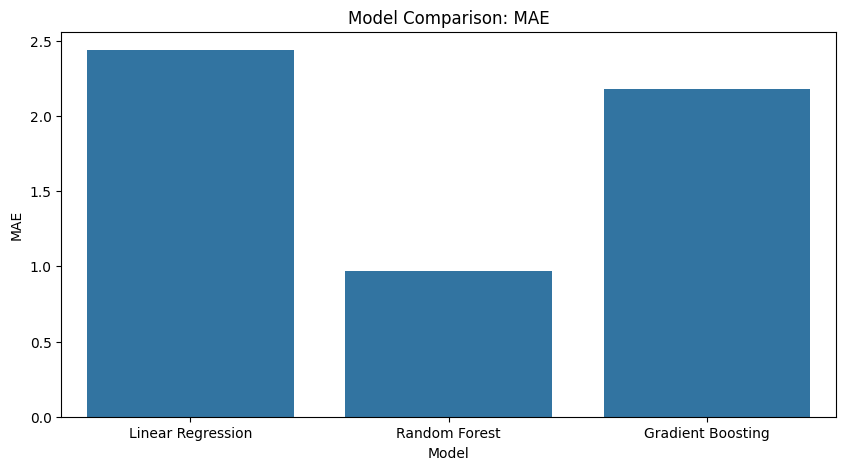

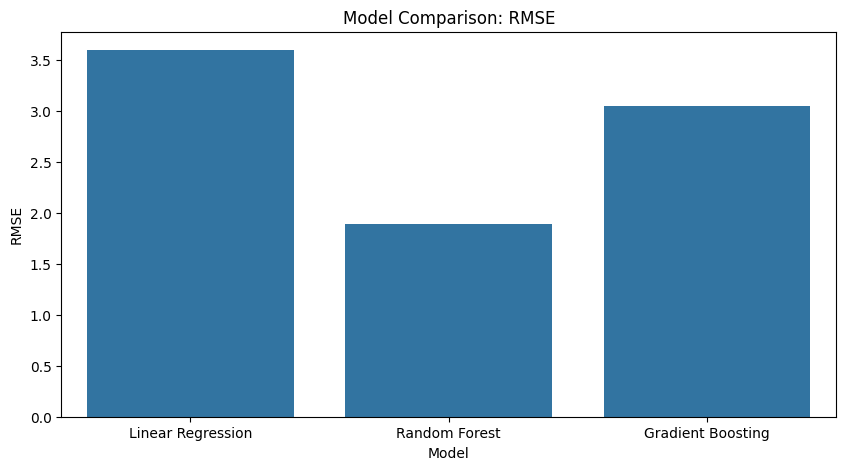

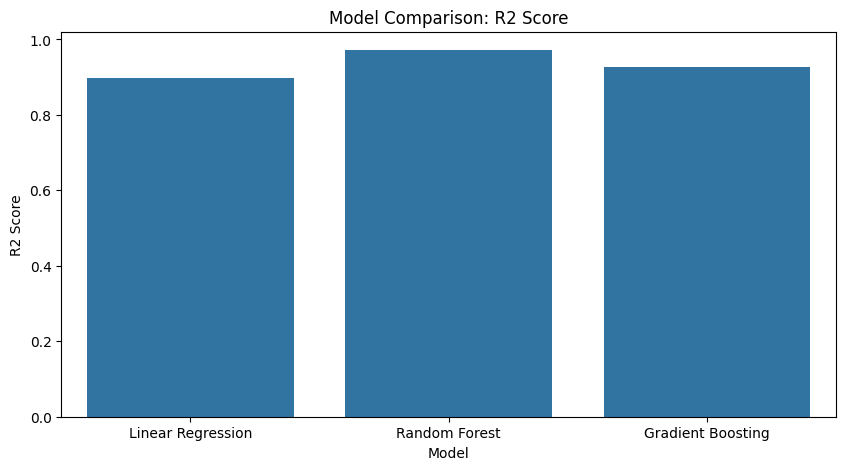

In [32]:
# Comparison bar charts (MAE/RMSE/R²)
plt.figure(figsize=(10,5))
sns.barplot(data=results_df, x="Model", y="MAE")
plt.title("Model Comparison: MAE")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=results_df, x="Model", y="RMSE")
plt.title("Model Comparison: RMSE")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=results_df, x="Model", y="R2 Score")
plt.title("Model Comparison: R2 Score")
plt.show()


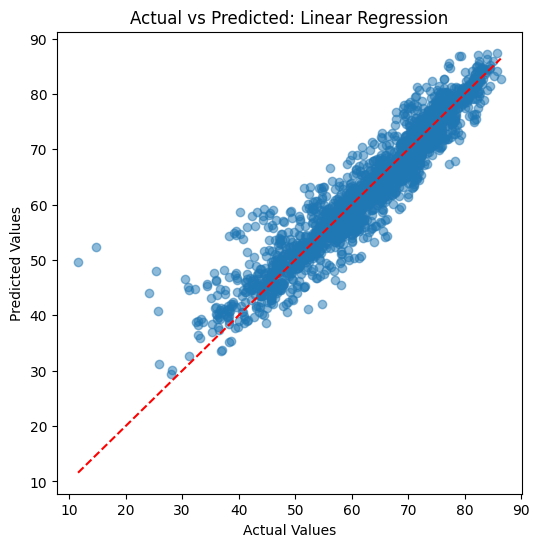

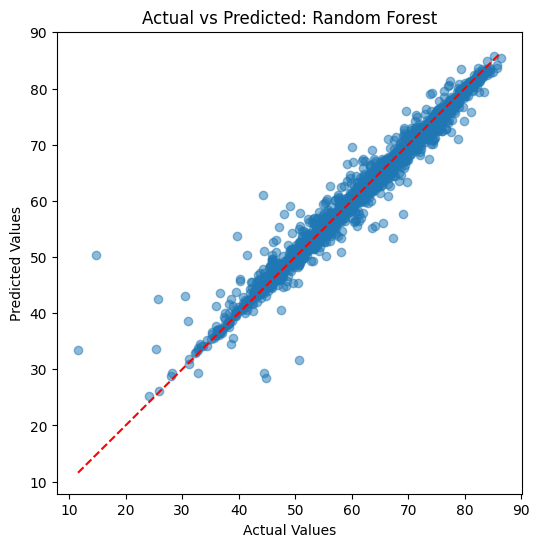

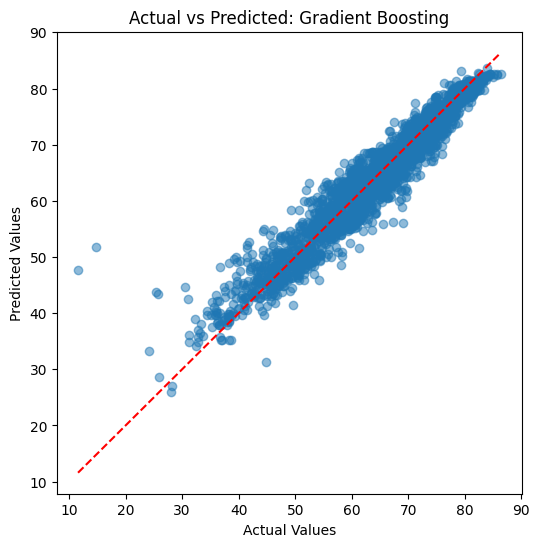

In [33]:
# Models and their labels
best_models = [
    ("Linear Regression", best_lr),
    ("Random Forest", best_rf),
    ("Gradient Boosting", best_gb)
]

# Prediction vs Actual plot for the BEST models
for model_name, model in best_models:
    preds = model.predict(X_test)

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, preds, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted: {model_name}")
    plt.show()


C:\Users\ENVY\AppData\Local\Temp\ipykernel_8536\133063996.py:10: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test_series = y_test.squeeze().ravel()


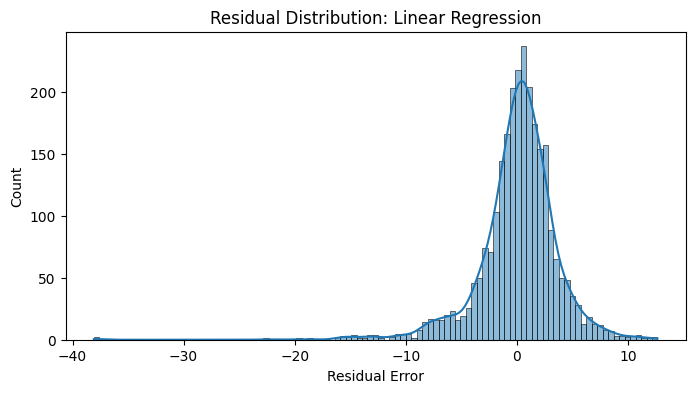

C:\Users\ENVY\AppData\Local\Temp\ipykernel_8536\133063996.py:10: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test_series = y_test.squeeze().ravel()


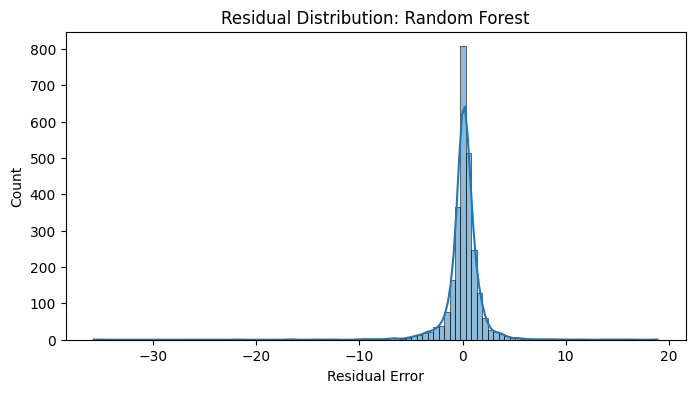

C:\Users\ENVY\AppData\Local\Temp\ipykernel_8536\133063996.py:10: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test_series = y_test.squeeze().ravel()


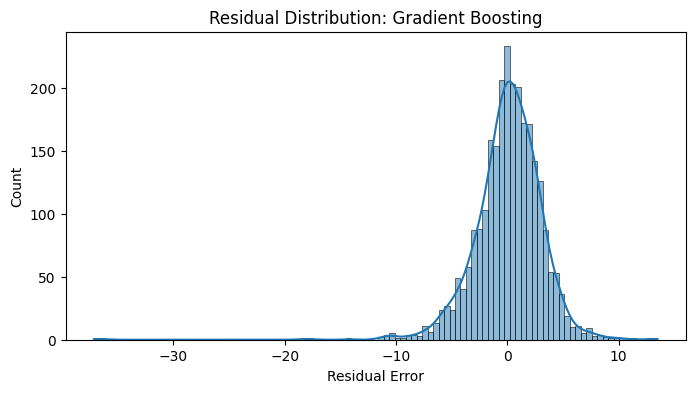

In [34]:
# Models and their labels
best_models = [
    ("Linear Regression", best_lr),
    ("Random Forest", best_rf),
    ("Gradient Boosting", best_gb),
]

for model_name, model in best_models:
    preds = model.predict(X_test).ravel()
    y_test_series = y_test.squeeze().ravel()
    residuals = y_test_series - preds

    plt.figure(figsize=(8,4))
    sns.histplot(residuals, kde=True)
    plt.title(f"Residual Distribution: {model_name}")
    plt.xlabel("Residual Error")
    plt.show()
